In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from thermo_property.thermo_properties import Get_ThermoProperties, Get_RelativeSpeed, Get_MachAltitude, Sutherland

from aero_property.PressureCoeff import Get_Pressure_Coeff
from aero_property.LiftCoeff import Get_LiftCoeff
from aero_property.DragCoeff import Reynolds, Get_Frot_Coeff, Get_Wall_Constraint, Get_Drag_Coeff, Get_Total_Drag

from thermo_property.LocalThermoProperties import Get_Local_Params
from profil_config.modelisation import AoA_Effect, Get_Local_Velocity, curv

from CAO_management.STL_to_CSV import Get_CSV
from CAO_management.TriangleAndSegment import TransformCSV
from CAO_management.ShowFigure import ShowLaunchersFigure

from graph_management.EvolThermoParams import Show_ThermoProperties
from graph_management.EvolAeroCoeff import Show_AeroCoeff

from CAO_management.vectors_2D import Get_2D_vectors

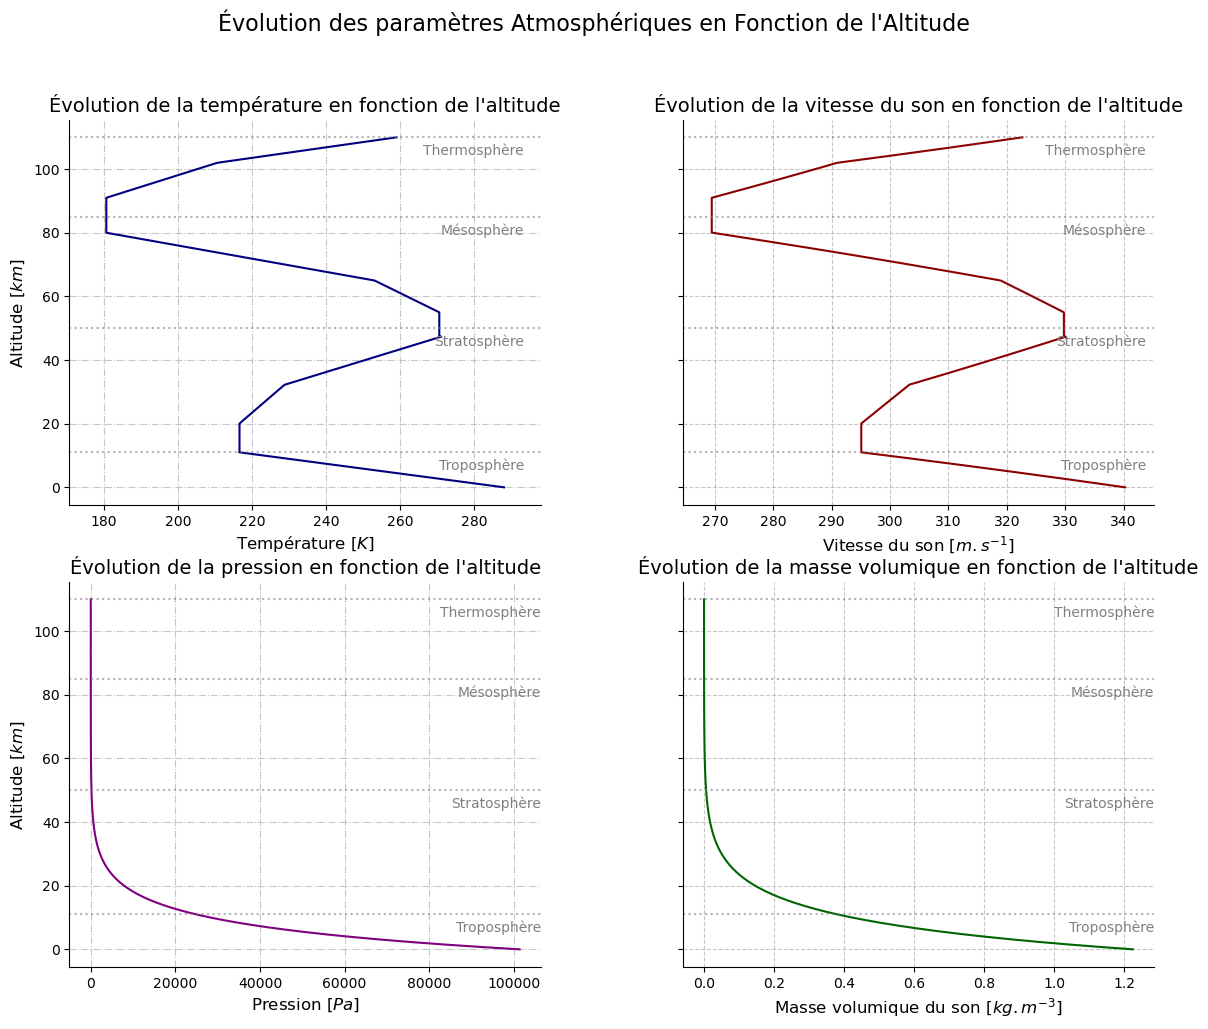

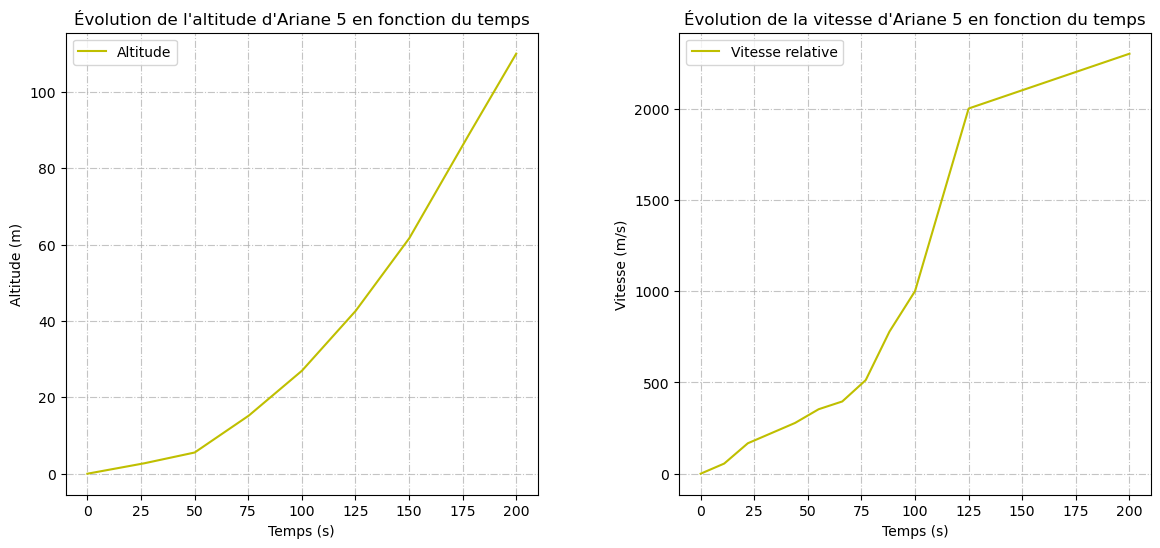

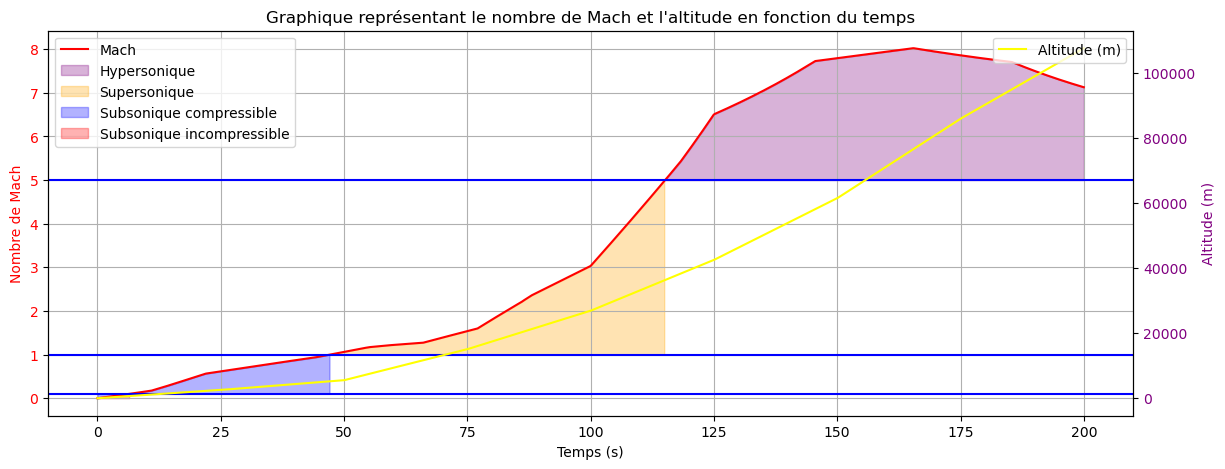

In [2]:
ThermoProperties_dict = Get_ThermoProperties()

AltVelTime = Get_RelativeSpeed()

Time_array, Mach_array, Altitude_array, P_dyn_array = Get_MachAltitude(ThermoProperties_dict=ThermoProperties_dict)

In [3]:
# --> Coiffe pour test

diameter = 5.45
radius = 0.5*diameter
x_shape = np.linspace(0, 17, 1000)
y_lower_ = -radius * (np.sqrt(x_shape) / np.max(np.sqrt(x_shape)))
y_upper_ = radius * (np.sqrt(x_shape) / np.max(np.sqrt(x_shape)))

section_idx = np.array([(0, 1000)])

In [4]:
# --> Ariane V modèle simple 2D

# x_shape, y_upper_, y_lower_ = Get_2D_vectors()
# section_idx = np.array([(0, 1000), (1000, 2000), (2000, 2200), (2200, 3000), (3000, 4000)])

In [5]:
# choix données pour étude comportement du lanceur
type = "mach"
# type = "altitude"

Target_mach = 7
Target_altitude = 50_000
gamma = 1.4

if type == "mach":
    idx = np.argmin(np.abs(Mach_array - Target_mach))
elif type == "altitude":
    idx = np.argmin(np.abs(Altitude_array - Target_altitude))

inf_cst = {key:value[idx] for key, value in ThermoProperties_dict.items()}
inf_cst["ALTITUDE"] = Altitude_array[idx]
inf_cst["MACH"] = Mach_array[idx]
inf_cst["VITESSE"] = AltVelTime["VITESSE"][idx]
inf_cst["VISCOSITÉ"] = Sutherland(T=inf_cst["TEMPERATURE"])
inf_cst['GAMMA'] = gamma
inf_cst["S_REF"] = 0.25 * np.pi * 5.4**2

AoA = np.radians(5.0)

In [6]:
# --> Partie inférieur
x_arr, y_lower, dev_angle_lower = AoA_Effect(x_arr=x_shape, y_arr=y_lower_, AoA=AoA)
v_local_lower = Get_Local_Velocity(v_inf=inf_cst["VITESSE"], EffectiveAngle=dev_angle_lower)

Mach = {
    "MACH_INF": inf_cst["MACH"],
    "MACH_LOCAL": v_local_lower / inf_cst["VITESSE DU SON"]
}

Velocity = {
    "V_INF": inf_cst["VITESSE"],
    "V_LOCAL": v_local_lower
}

LocalParams_Lower = {"PRESSION": [], "TEMPERATURE": [],"MASSE VOLUMIQUE": []}

for (start, stop) in section_idx:
    local_params = Get_Local_Params(
        inf_cst=inf_cst, 
        Mach=Mach, 
        Velocity=Velocity, 
        deviation_angle=dev_angle_lower[start:stop], 
        basic_gamma=gamma
    )
    
    LocalParams_Lower["PRESSION"].append(local_params["PRESSION"])
    LocalParams_Lower["TEMPERATURE"].append(local_params["TEMPERATURE"])
    LocalParams_Lower["MASSE VOLUMIQUE"].append(local_params["MASSE VOLUMIQUE"])

for key in LocalParams_Lower:
    LocalParams_Lower[key] = np.concatenate([np.ravel(np.array(arr)) for arr in LocalParams_Lower[key]]).flatten()

# --> Partie supérieur
x_arr, y_upper, dev_angle_upper = AoA_Effect(x_arr=x_shape, y_arr=y_upper_, AoA=AoA)
v_local_upper = Get_Local_Velocity(v_inf=inf_cst["VITESSE"], EffectiveAngle=dev_angle_upper)

Mach = {
    "MACH_INF": inf_cst["MACH"],
    "MACH_LOCAL": v_local_upper / inf_cst["VITESSE DU SON"]
}

Velocity = {
    "V_INF": inf_cst["VITESSE"],
    "V_LOCAL": v_local_upper
}

LocalParams_Upper = {"PRESSION": [], "TEMPERATURE": [],"MASSE VOLUMIQUE": []}

for (start, stop) in section_idx:
    local_params = Get_Local_Params(
        inf_cst=inf_cst, 
        Mach=Mach, 
        Velocity=Velocity, 
        deviation_angle=dev_angle_upper[start:stop], 
        basic_gamma=gamma
    )
    
    LocalParams_Upper["PRESSION"].append(local_params["PRESSION"])
    LocalParams_Upper["TEMPERATURE"].append(local_params["TEMPERATURE"])
    LocalParams_Upper["MASSE VOLUMIQUE"].append(local_params["MASSE VOLUMIQUE"])

for key in LocalParams_Upper:
    LocalParams_Upper[key] = np.concatenate([np.ravel(np.array(arr)) for arr in LocalParams_Upper[key]]).flatten()

ds_x_upper_list = []
s_x_upper_list = []
ds_x_lower_list = []
s_x_lower_list = []

for (start, stop) in section_idx:
    ds_x_up, s_x_up = curv(x_arr=x_shape[start:stop], y_arr=y_upper[start:stop])
    ds_x_upper_list.append(ds_x_up)
    s_x_upper_list.append(s_x_up)

    ds_x_low, s_x_low = curv(x_arr=x_shape[start:stop], y_arr=y_lower[start:stop])
    ds_x_lower_list.append(ds_x_low)
    s_x_lower_list.append(s_x_low)

ds_x_upper = np.concatenate(ds_x_upper_list).flatten()
s_x_upper = np.concatenate(s_x_upper_list).flatten()
ds_x_lower = np.concatenate(ds_x_lower_list).flatten()
s_x_lower = np.concatenate(s_x_lower_list).flatten()

c:\ProgramData\miniconda3\envs\Elisa5\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\miniconda3\envs\Elisa5\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


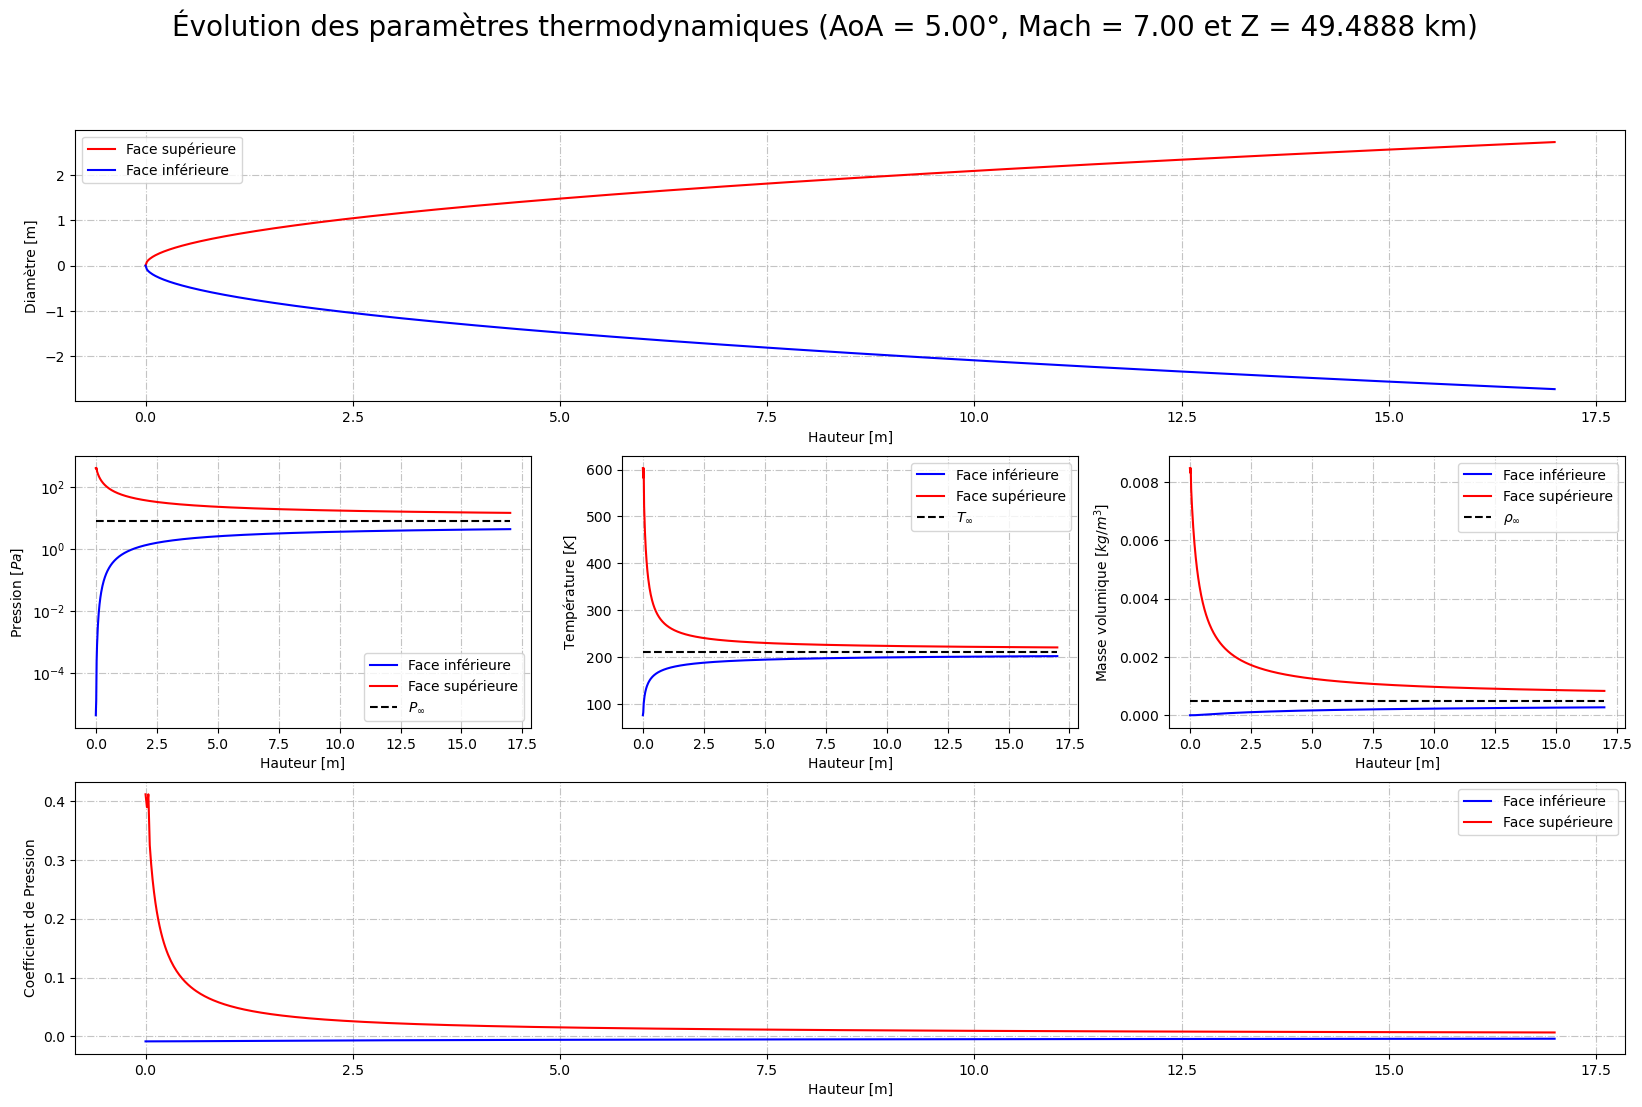

In [7]:
profil_shape = {"x_shape": x_shape, "y_upper_": y_upper_, "y_lower_": y_lower_}

cst_dict = {"AoA": AoA, "INF_CST": inf_cst,}
LocalParams = {"LOWER": LocalParams_Lower, "UPPER": LocalParams_Upper}

Cp_lower = Get_Pressure_Coeff(Mach=inf_cst["MACH"], inf_cst=inf_cst, P=LocalParams_Lower["PRESSION"])
Cp_upper = Get_Pressure_Coeff(Mach=inf_cst["MACH"], inf_cst=inf_cst, P=LocalParams_Upper["PRESSION"])
PressureCoeff = {"UPPER": Cp_upper, "LOWER": Cp_lower}

Show_ThermoProperties(profil_shape=profil_shape, cst_dict=cst_dict, LocalParams=LocalParams, PressureCoeff=PressureCoeff)

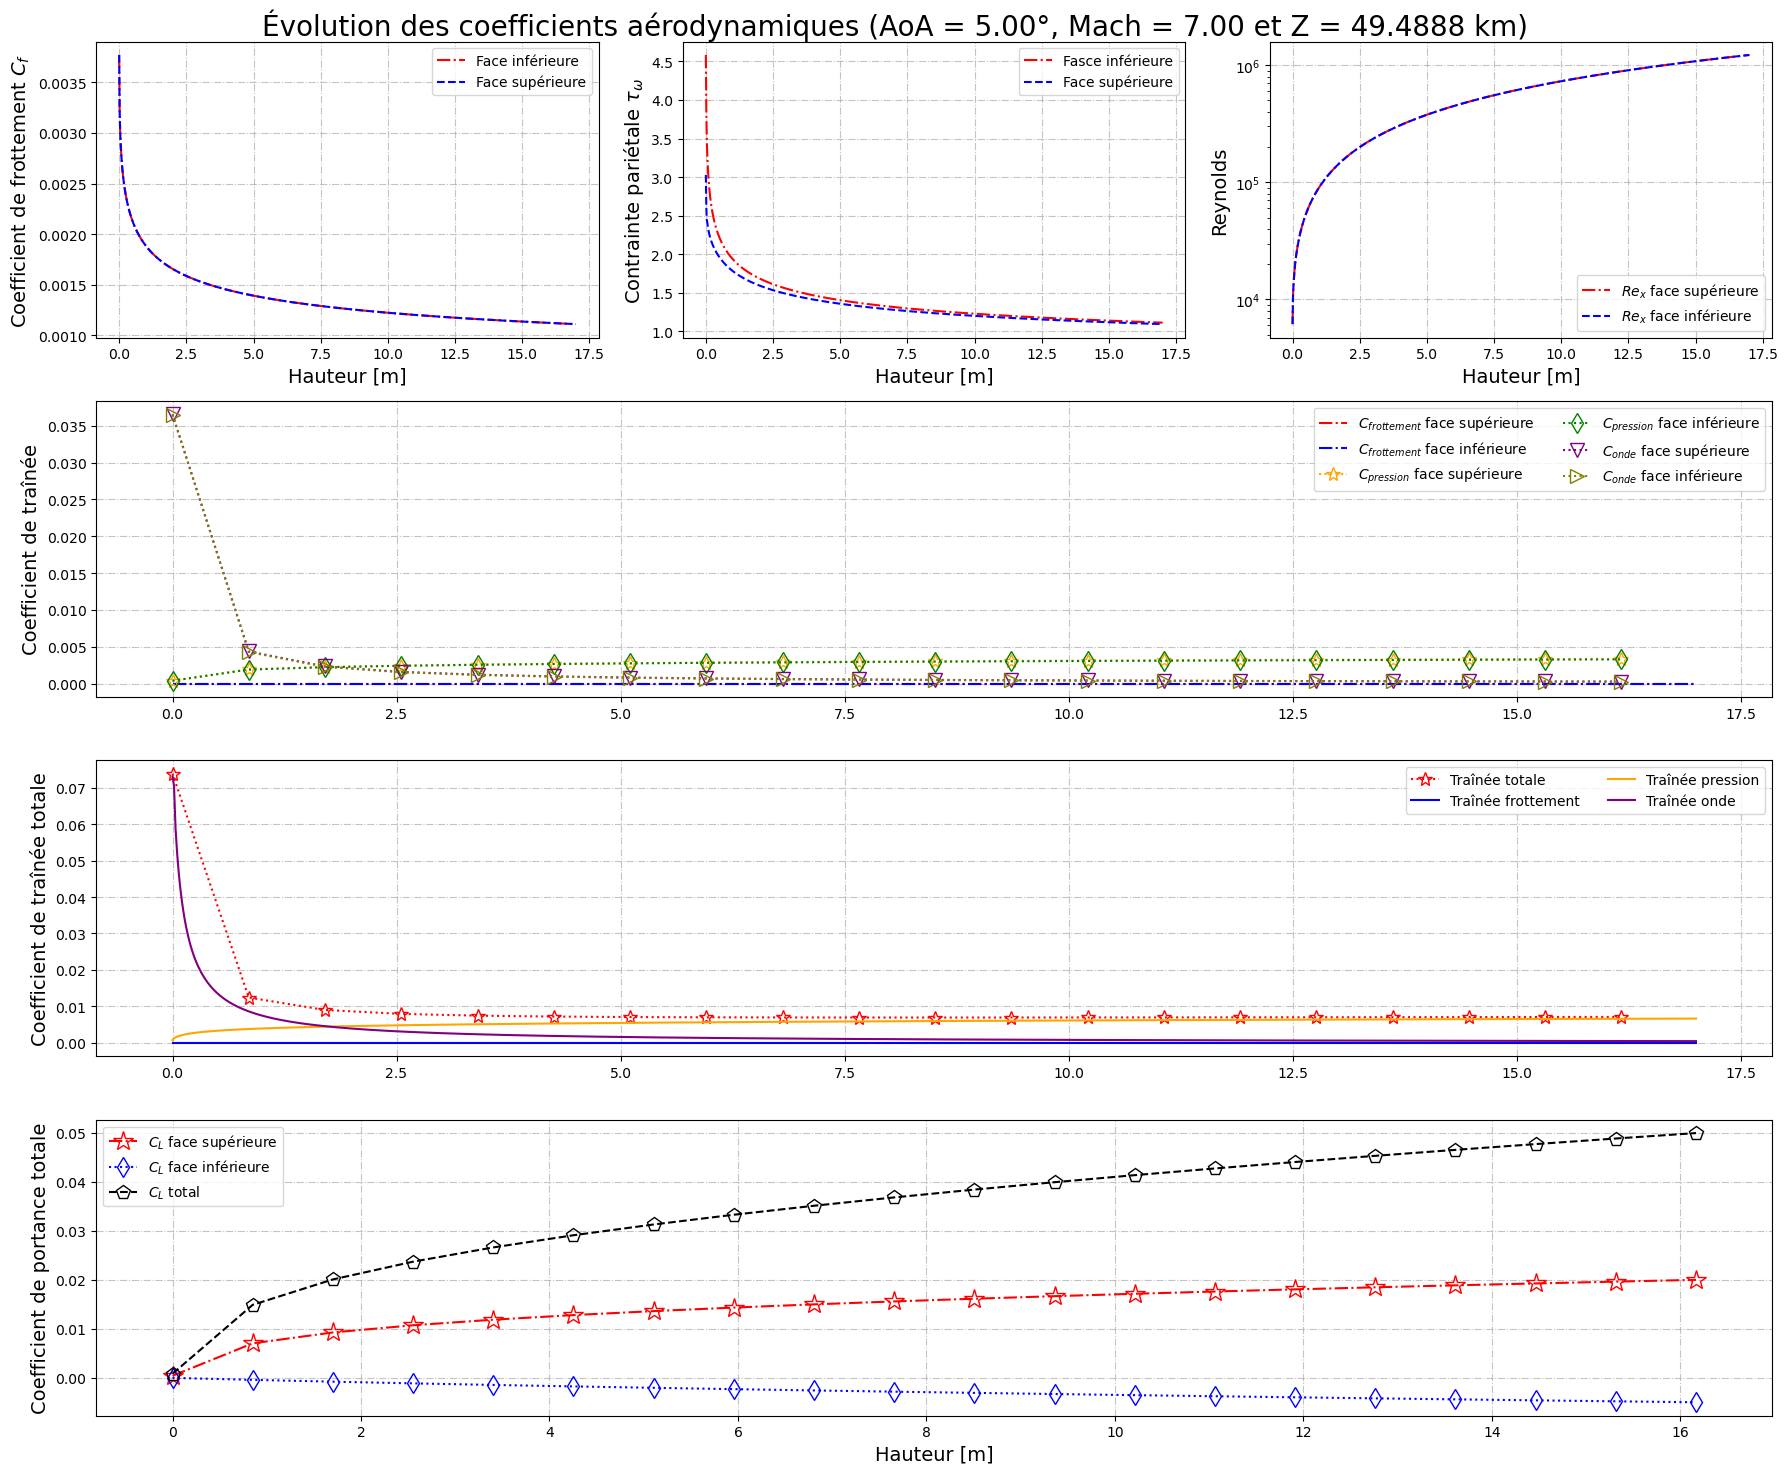

In [8]:
Temperature_Lower = {"LOCAL": LocalParams_Lower["TEMPERATURE"], "T_INF": inf_cst["TEMPERATURE"]}
Re_upper = Reynolds(rho=inf_cst["MASSE VOLUMIQUE"], velocity=inf_cst["VITESSE"], viscosity=inf_cst["VISCOSITÉ"], s_x=s_x_upper)
Cf_upper = Get_Frot_Coeff(Reynold=Re_upper, Mach=inf_cst["MACH"])
tau_w_upper = Get_Wall_Constraint(Mach=inf_cst["MACH"], Cf=Cf_upper, rho=inf_cst["MASSE VOLUMIQUE"], velocity=inf_cst["VITESSE"], Temperature=Temperature_Lower)

Cd_frott_upper, Cd_press_upper, Cd_wave_upper = Get_Drag_Coeff(tau_w=tau_w_upper, Cp=Cp_upper, x_arr=x_shape, y_arr=y_upper, 
                                                               ds_x_arr=ds_x_upper, inf_cst=inf_cst, dev_angle=dev_angle_upper)

Temperature_Upper = {"LOCAL": LocalParams_Upper["TEMPERATURE"], "T_INF": inf_cst["TEMPERATURE"]}
Re_lower = Reynolds(rho=inf_cst["MASSE VOLUMIQUE"], velocity=inf_cst["VITESSE"], viscosity=inf_cst["VISCOSITÉ"], s_x=s_x_lower)
Cf_lower = Get_Frot_Coeff(Reynold=Re_upper, Mach=inf_cst["MACH"])
tau_w_lower = Get_Wall_Constraint(Mach=inf_cst["MACH"], Cf=Cf_lower, rho=inf_cst["MASSE VOLUMIQUE"], velocity=inf_cst["VITESSE"],  Temperature=Temperature_Upper)

Cd_frott_lower, Cd_press_lower, Cd_wave_lower = Get_Drag_Coeff(tau_w=tau_w_lower, Cp=Cp_lower, x_arr=x_shape, y_arr=y_lower, 
                                                               ds_x_arr=ds_x_lower, inf_cst=inf_cst, dev_angle=dev_angle_lower)

Cd_frott = {"UPP": Cd_frott_upper, "LOW": Cd_frott_lower}
Cd_press = {"UPP": Cd_press_upper, "LOW": Cd_press_lower} 
Cd_wave = {"UPP": Cd_wave_upper, "LOW": Cd_wave_lower}

Cd_tot, Cd_tot_frott, Cd_tot_pression, Cd_tot_wave = Get_Total_Drag(Cd_frott=Cd_frott, Cd_press=Cd_press, Cd_wave=Cd_wave)

Cp_dict = {"UPP": Cp_upper, "LOW": Cp_lower}
ds_dict = {"UPP": ds_x_upper, "LOW": ds_x_lower}
theta_dict = {"UPP": dev_angle_upper, "LOW": dev_angle_lower}

CL_x, Cl_x_upper, Cl_x_lower = Get_LiftCoeff(Cp_dict=Cp_dict, ds_dict=ds_dict, theta_dict=theta_dict, x_arr=x_shape)

DragCoeff = {
    "UPPER": {"FROTTEMENT": Cd_frott_upper, "PRESSION": Cd_press_upper, "ONDE": Cd_wave_upper},
    "LOWER": {"FROTTEMENT": Cd_frott_lower, "PRESSION": Cd_press_lower, "ONDE": Cd_wave_lower},
    "TOTAL": {"FROTTEMENT": Cd_tot_frott, "PRESSION": Cd_tot_pression, "ONDE": Cd_tot_wave, "ALL": Cd_tot}
}

LiftCoeff = {"UPPER": Cl_x_upper, "LOWER": Cl_x_lower, "TOTAL": CL_x}

DragComponent = {
    "UPPER": {"CF": Cf_upper, "TAU_W": tau_w_upper, "RE": Re_upper},
    "LOWER": {"CF": Cf_lower, "TAU_W": tau_w_lower, "RE": Re_lower}
}

Show_AeroCoeff(cst_dict=cst_dict, DragCoeff=DragCoeff, LiftCoeff=LiftCoeff, x_shape=profil_shape["x_shape"], DragComponent=DragComponent)

Conversion terminée ! Fichier enregistré sous c:\Users\plamb\Desktop\Elisa Aerospace\Elisa 5\Aerodynamique des lanceurs\Projet\src\../docs\CSV_files\ArianeV.csv


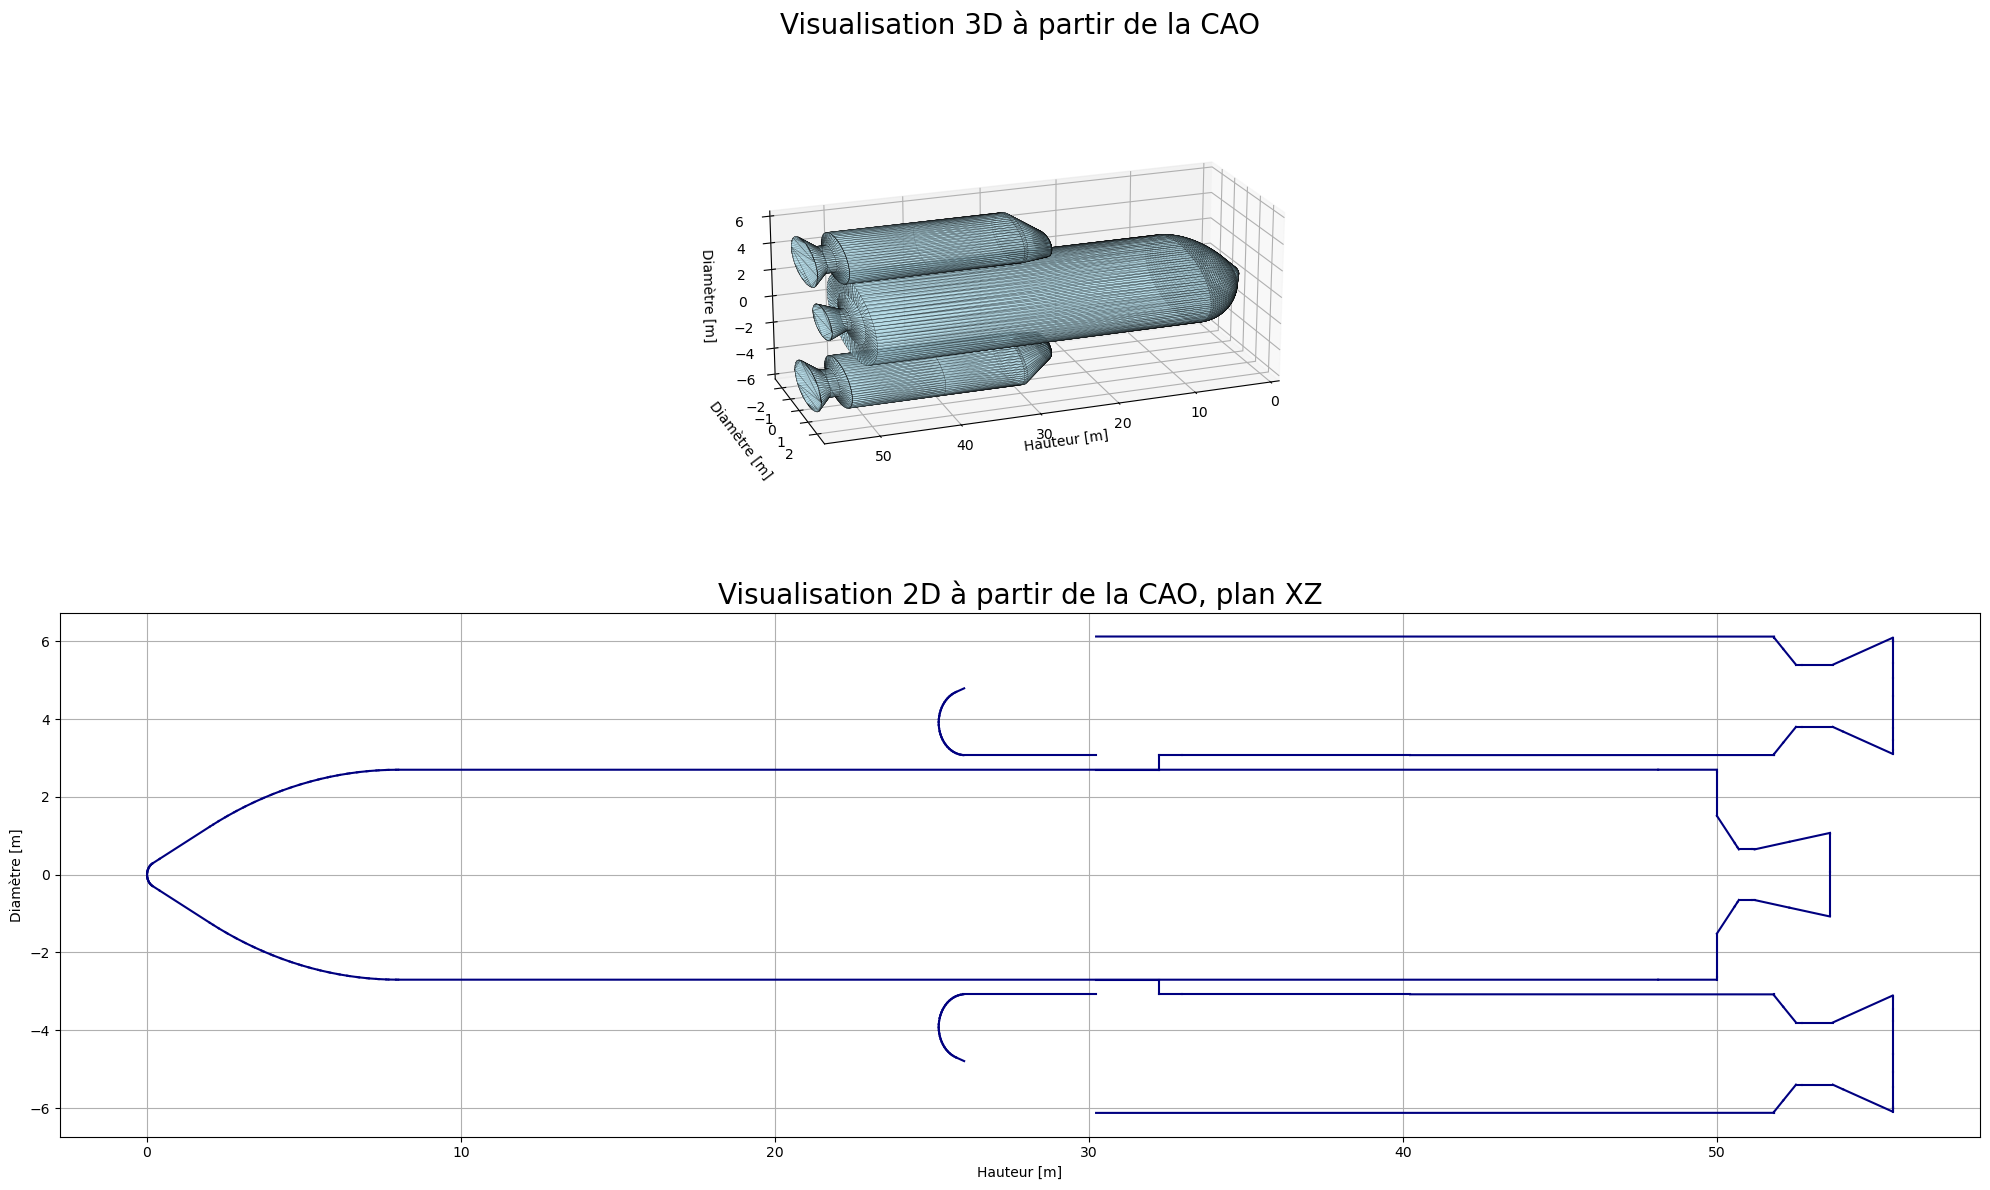

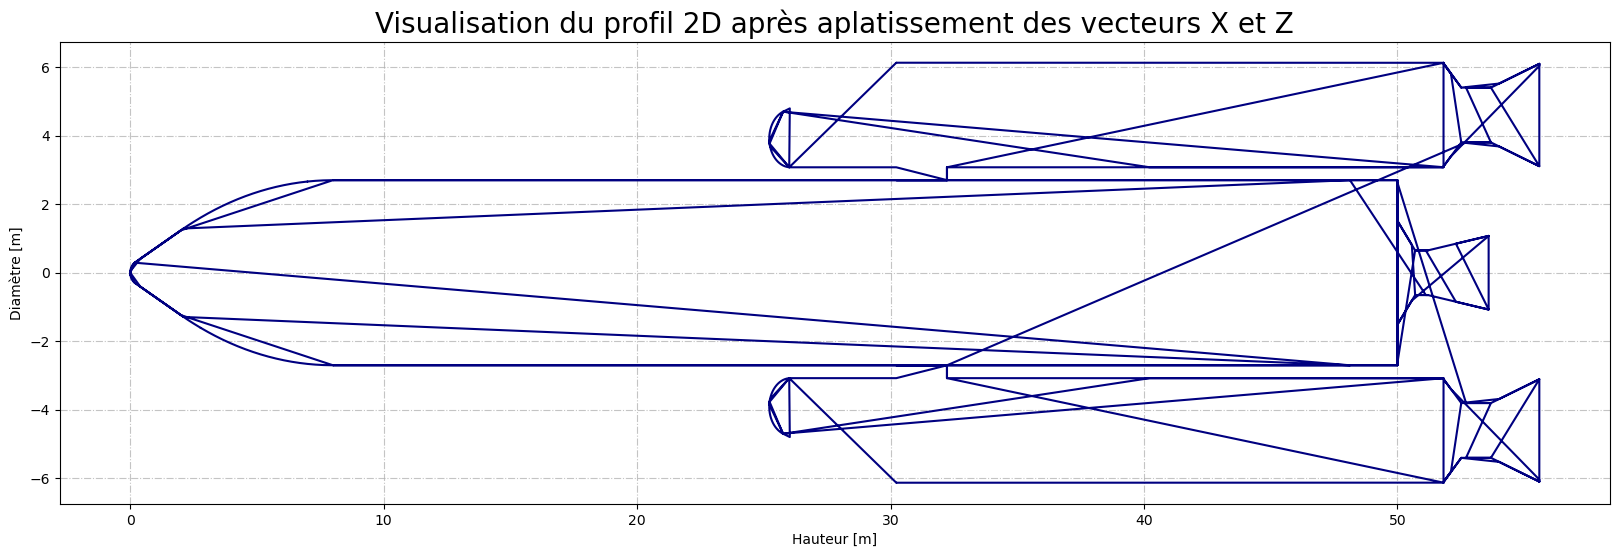

In [9]:
csv_file = Get_CSV(stl_name="ArianeV.stl", csv_name="ArianeV.csv")
triangles_ArianeV, segments_ArianeV = TransformCSV(csv_file=csv_file, Y_FIXE=0.0)
Z_launcher, X_launcher = ShowLaunchersFigure(trianglesLauncher=triangles_ArianeV, segmentsLauncher=segments_ArianeV)